# IV & Average Causal Response
In the first part of this notebook we reproduce IV/Average Causal Response results for the Quarter of Birth-data presented in *MHE* (e.g. Table 4.1.1 p.124). According to II. Theorem 4.5.3 the Wald estimator can be written as a weighted sum with explicit weights (see  II. Theorem 4.5.3.), which we reproduce as well. These formulas are presented in *MHE*. However, the summands themselves seem to be inaccessible.

In the second part of the notebook, we try to apply the methods developed in Angrist/Abadie/Imbens *Instrumental Variables Estimates of The Effect of Subsidized Training on the Quantiles of Trainee Earnings* to obtain estimates of these contributions.

The settings of the ACR theorem is the following. We assume a model $Z\rightarrow S\rightarrow Y$ with binary $Z$, discrete $S$ and continuous $Y$, and write $S = Z\cdot S_1+(1-Z)\cdot S_0$ and $Y = \sum_{s\geq 0}(Y_s-Y_{s-1})\cdot (S\geq s)$, $Y_{-1}=0$.

The ACR theorem (*MHE Theorem 4.5.3*) states the following.


Given the assumptions 
> - ACR1: $\{Y_s, S\}$ are jointly independet of Z given $X$.
> - ACR2: $E[S_1-S_0]\neq 0$,
> - ACR3: $S_1\geq S_0$ almost surely.

the Wald estimator is a weighted sum:

> $ \frac{E[Y|Z=1]-E[Y|Z=0]}{E[S|Z=1]-E[S|Z=0]} = \sum_s \omega_s E[Y_{s}-Y_{s-1}|S_1\geq s >S_0],\ \ \omega_s = P(S_1\geq s>S_0)/\sum_t  P(S_1\geq t>S_0)$,

and the weights can be computed explicitely:
> $P(S_1>=s>S_0) = P(S<s|Z=0)-P(S<s|Z=1)$.


In contrast, for the individual summands in the ACR-formula  -$E[Y_s-Y_{s-1}|S_1\geq s>S_0]$ -
this seems to be not true. We are interested in using Abadie's $\kappa$-Theorem (*MHE Theorem 4.5.2*) to estimate these.

Declaring $D(t) = (S>=t)$ we claim that $D(t)$ satisfies the conditions ACR 1-3.

  - D1: $\{Y_s, D(t)\}$ are jointly independent of $Z$ given $X$.
  - D2: $E[D(t)_1-D(t)_0|X]\ne 0$
  - D3: $D(t)_1>=D(t)_0$ almost surely.

D1 follows directly from the ACR1 and D3 is equivalent to ACR3.

For D2:

$E[D(t)_1-D(t)_0|X]\\
= P(S\geq t|Z=1, X) - P(S\geq t|Z=0, X)\\ 
= -P(S<t|Z=1, X) + P(S<t|Z=0, X)\\
= P(S_{1}\geq t>S_0|X)>0$

The significance of $D(t)$ comes from the fact that the complier condition $D(t)_1>D(t)_0$ is actually equivalent to $S_1\geq s>S_0$. Hence, the $D(t)$-compliers give the different summands in the ACR theorem.

Using $D1-D3$, we conclude from Abadie/Angrist/Imbens Lemma 2.1 that the treatment status $D(t)$ is independent of potential outcomes $\{Y_s\}$ given X and $D(t)_1>D(t)_0$.
Moreover, a treatment effect can be estimated by means of the
$\kappa$-function:

>With $\kappa_t = 1- (1-D(t))Z/P(Z) - D(t)(1-Z)/(1-P(Z))$ and
>$\alpha, \beta = argmin(\kappa_t \cdot |Y-aD(t) -X'b|^2)$,
>
>we have $\alpha\sim E[Y_{S_1}-Y_{S_0}|D(t)_1>D(t)_0]$.

We use the strategy as described in MHE to implement this estimation. 
However, the result is not precisely what we are after - $E[Y_{t}-Y_{t-1}|D(t)_1>D(t)_0]$.

We correct this by regressing (hand-wavingly..) directly on $S$ instead of $D(t)$:

>$\alpha, \beta = argmin(\kappa_t \cdot |Y-aS -X'b|^2)$.


Remark:
- We find that the estimation is a subtle issue. For instance, in the case of the simulated data we get better results when working with $E[Z|Y,X,S=s]$ instead of $E[Z|Y,X,D(t)]$.

- Theoretically, the modified version $\kappa_{t,t+1} = 1- (1-D(t))Z/P(Z) - D(t+1)(1-Z)/(1-P(Z))$ yields a weight
for the intersection of $D(t)_1>D(t)_0$ and $D(t+1)_1>D(t+1)_0$, i.e. $S_1>=t+1>t>S_0$. Hence, potentially one could use this to calculate contributions of slices $S_1=t>S_0$, $S_1>t=S_0$.



For verification, with the flag *SIM* simulated data can be used instead of the original data.

In [1]:
#SIM=True
SIM=False

## 0) Imports & Convenience Functions

In [2]:
from IPython.display import clear_output
import os
import pandas
import numpy
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
from linearmodels import IV2SLS
import requests

## 1)  Load Dataset

In [3]:
def get_sim():
    N = 300000
    df_gen = pandas.DataFrame({"yob": numpy.random.randint(1, 11,N) , 
                               "qob": numpy.random.randint(0,2, N), 
                               "pob": numpy.random.randint(1,6, N)})

    df_gen["qob"] = df_gen["qob"] * 3 +1 
    
    abi = educ =  numpy.random.randint(0,3, N)
    df_gen["educ"] = (educ==0)*numpy.random.normal(12,1 , N) + (educ==1)*numpy.random.normal(16,1 , N) + (educ==2)*numpy.random.normal(9,1 , N) 
    df_gen["educ"] = df_gen["educ"].astype("int")
    df_gen["educ"] += (df_gen["educ"].astype("int").isin([10]))*(df_gen["qob"]==4)*numpy.random.randint(1,2, N)
    df_gen["educ"] = df_gen["educ"].astype("int").clip(5,20)
    df_gen["lwklywge"] = df_gen["educ"]*.15 +  (abi-1)*1
    df_gen["lwklywge"] = (df_gen["lwklywge"].clip(0,20)+.1)+6
    
    return df_gen

In [4]:
if SIM:
    df = get_sim()
else:
    url = "https://economics.mit.edu/sites/default/files/publications/asciiqob.zip"
    u = requests.get(url)
    raw_zip = u.content

    tmp_f = "tmp.zip"
    with open("tmp.zip", "wb") as f:
        f.write(raw_zip)

    df = pandas.read_csv(tmp_f, sep="        ", header=None )
    os.remove(tmp_f)
    df.columns = ['lwklywge', 'educ', 'yob', 'qob', 'pob']


for qob in sorted(df["qob"].unique()):
    df[f"qob_{qob}"] = (df["qob"]==qob)*1.0
for yob in sorted(df["yob"].unique()):
    df[f"yob_{yob}"] = (df["yob"]==yob)*1.0
for pob in sorted(df["pob"].unique()):
    df[f"pob_{pob}"] = (df["pob"]==pob)*1.0

#pob_dummies

cols = ["const", "educ"]
yob_dummies = [c for c in df.columns if "yob_" in c]
pob_dummies = [c for c in df.columns if "pob_" in c]
qob_dummies = [c for c in df.columns if "qob_" in c]

additional_cov = ["const"]
#additional_cov +=yob_dummies
#additional_cov +=pob_dummies
#additional_cov +=yob_dummies

df["const"] = 1

df= df[df["qob"].isin([1,2,3,4])]
df.head()

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,lwklywge,educ,yob,qob,pob,qob_1,qob_2,qob_3,qob_4,yob_30,...,pob_47,pob_48,pob_49,pob_50,pob_51,pob_53,pob_54,pob_55,pob_56,const
0,5.790019,12,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,5.952494,11,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,5.315949,12,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,5.595926,12,30,1,45,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,6.068915,12,30,1,37,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## 2) OLS and IV

Here we reproduce the OLS and IV estimates of the return of schooling of .071 resp .10 respectively.

In [5]:
# Cf. MHE Table 4.1.1 (p. 124) --> OLS (2)

endog=df[["lwklywge"]] 
exog=df[["educ"]+additional_cov]
mod = sm.OLS(endog=endog, exog=exog, check_rank=False)
res = mod.fit()
res.summary()

/data/user/0/ru.iiec.pydroid3/files/aarch64-linux-android/lib/python3.9/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['check_rank']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lwklywge   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                 4.378e+04
Date:                Fri, 23 Jun 2023   Prob (F-statistic):               0.00
Time:                        20:32:00   Log-Likelihood:            -3.1935e+05
No. Observations:              329509   AIC:                         6.387e+05
Df Residuals:                  329507   BIC:                         6.387e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
educ           0.0709      0.000    209.243      0.000       0.070       0.072
const          4.9952      0.004   1118.882      0.000       4.986       5.004
==============================================================================
Omnibus:                   191064.440   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4082110.366
Skew:                          -2.377   Prob(JB):                         0.00
Kurtosis:                      19.575   Cond. No.                         53.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
from linearmodels import IV2SLS, IVGMM, IVGMMCUE, IVLIML
df["Z"] = df["qob"].isin([3,4])

dependent =df[["lwklywge"]] 
endog= df["educ"]

ivmod = IV2SLS(dependent=dependent, exog=df[additional_cov], endog = endog, instruments=df["Z"])
res_2sls = ivmod.fit()
res_2sls.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               lwklywge   R-squared:                      0.0750
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0750
No. Observations:              329509   F-statistic:                    27.737
Date:                Fri, Jun 23 2023   P-value (F-stat)                0.0000
Time:                        20:32:01   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.4519     0.2750     16.191     0.0000      3.9130      4.9908
educ           0.1134     0.0215     5.2666     0.0000      0.0712      0.1556
==============================================================================

Endogenous: educ
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
"""

## 3) ACR


### ACR Weights



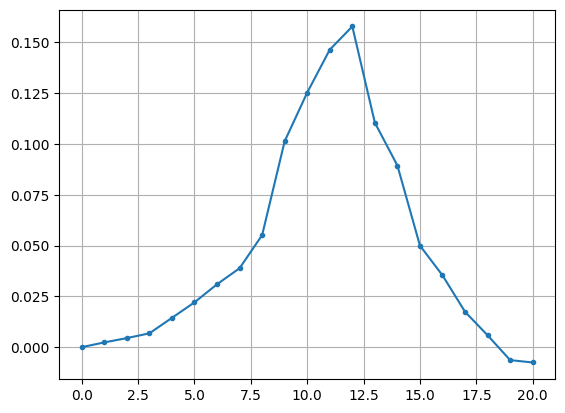

In [7]:
Z = df["qob"].isin([3,4])

denominator = df[~Z]["educ"].mean() - df[Z]["educ"].mean()

numerators = []
for s in df["educ"].unique():
    
    numerator = -(df[Z]["educ"]<s).sum()/Z.sum()+(df[~Z]["educ"]<s).sum()/(~Z).sum()
    numerators.append({"s": s, "omega": -numerator/(1)})
    
    
df_omega = pandas.DataFrame(numerators).sort_values("s")

df_omega["omega"] = df_omega["omega"]/df_omega["omega"].sum()

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(df_omega["s"], df_omega["omega"], marker=".")
plt.grid()
plt.show()


### ACR summands


In [8]:
import os
import pandas
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Probit
from linearmodels import IV2SLS
from sklearn.linear_model import QuantileRegressor, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate
import numpy
from sklearn.ensemble import RandomForestClassifier

@property
def params(self):
    return pandas.Series(data = self.coef_, index=self.feature_names_in_)
QuantileRegressor.params = params

class ProbitWrapper:
    """Provides sklearn API for statsmodels Probit"""
        
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.model = Probit(y, X)
        self.res = self.model.fit(max_iter=200, method= "newton")
    
    def predict_proba(self, X):
        p1 = self.res.predict(X)
        p0 = 1-p1
        return pandas.concat([p0, p1], axis=1).values
    
    def predict(self,X):
        return self.res.predict(X)
    
    def get_params(self, deep=False):
        return {}
    @property
    def classes_(self):
        return numpy.array([0,1])
    
RF_KWARGS_DEF = {
    "n_estimators": 100, 
    "criterion":'gini',
    "max_depth":None,
    "min_samples_split":2,
    "min_samples_leaf":1,
    "min_weight_fraction_leaf":0.0,
    "max_features":'auto',
    "max_leaf_nodes":None,
    "min_impurity_decrease":0.0,
    "bootstrap":True,
    "oob_score":False,
    "n_jobs":None,
    "random_state":None,
    "verbose":0,
    "warm_start":False,
    "class_weight":None,
}

RF_KWARGS_MAX = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_MAX["max_depth"] = 10000
RF_KWARGS_MAX["bootstrap"] = False

RF_KWARGS_1 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_1["max_depth"] = 4
RF_KWARGS_1["min_samples_split"] = 10
RF_KWARGS_1["min_samples_leaf"] = 10
RF_KWARGS_1["oob_score"] = True
RF_KWARGS_1["max_samples"] = .7

RF_KWARGS_2 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_2["max_depth"] = 8
RF_KWARGS_2["min_samples_split"] = 5
RF_KWARGS_2["min_samples_leaf"] = 5
RF_KWARGS_2["oob_score"] = True
RF_KWARGS_2["max_samples"] = .7

RF_KWARGS_3 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_3["max_depth"] = 16
RF_KWARGS_3["min_samples_split"] = 5
RF_KWARGS_3["min_samples_leaf"] = 5
RF_KWARGS_3["max_samples"] = .7
RF_KWARGS_3["oob_score"] = True

RF_KWARGS_4 = {k:v for k,v in RF_KWARGS_DEF.items()}
RF_KWARGS_4["max_depth"] = 16
RF_KWARGS_4["min_samples_split"] = 3
RF_KWARGS_4["min_samples_leaf"] = 3
RF_KWARGS_4["max_samples"] = .7
RF_KWARGS_4["oob_score"] = True

In [9]:
from sklearn.linear_model import LinearRegression

def fit_model(model_name, model_kwargs, X, y):
    modelname2model = {"probit": ProbitWrapper, 
                       "rf": RandomForestClassifier, 
                       "logit": LogisticRegression,
                       "logitcv": LogisticRegressionCV,                       
                        "linear": LinearRegression
                      }
    Model = modelname2model[model_name]
    model = Model(**model_kwargs)
    model.fit(y=y, X=X)
    if model_name in ["probit", "rf", "logit", "logitcv"]:
        pred = model.predict_proba(X)[:,1]
        pred = pandas.Series(pred, X.index)
        cv = -cross_validate(model, X, y, cv=2, scoring="roc_auc")["test_score"]
                
    elif model_name in ["linear"]:
        pred = model.predict(X)
        pred = pandas.Series(pred, X.index)
        cv = cross_validate(model, X, y, cv=2, scoring="neg_mean_squared_error")["test_score"]
    return pred, cv

def get_p_z_cond(xs, ys, zs, ds, model_name, kwargs, sep_d=True):
    p_z_given_y_x_d0 = 0*ds + 1000*0
    p_z_given_y_x_d1 = 0*ds + 1000*0
    p_z_given_y_x_d = 0*ds+1000*0

    p_z_given_x = 0*ds + 1000*0
    all_pred =[]
    all_cv = []
    deg = kwargs["deg"]
    model_kwargs = kwargs["model_kwargs"]
    if sep_d:
        for d in [0,1]:
            m_d = ds==d
            y, X = zs[m_d], pandas.concat([xs[m_d]] + [ys[m_d]**k for k in range(1, deg+1)], axis=1)

            if y.nunique()==1:
                pred, cv = y, numpy.array([0])
            else:
                pred, cv = fit_model(model_name, model_kwargs, X, y)
            all_pred.append(pred[m_d])

            if d==0:
                p_z_given_y_x_d0.loc[m_d] = pred[m_d]
                cv0 = numpy.mean(-cv)
            elif d==1:
                p_z_given_y_x_d1.loc[m_d] = pred[m_d]
                cv1 = numpy.mean(-cv)
            else:
                raise AssertionError("")
    else:
        #y, X = zs, pandas.concat([xs]  + [ys**k for k in range(1, deg+1)], axis=1)
        #y, X = zs, pandas.concat([xs] + [ds] + [ys*ds] + [ys**k for k in range(1, deg+1)], axis=1)
        y, X = zs, pandas.concat([xs] + [ds] + [ys**k for k in range(1, deg+1)], axis=1)
        X.columns = list(range(len(X.columns)))
        
        if y.nunique()==1:
            pred, cv = y, numpy.array([0])
        else:
            pred, cv = fit_model(model_name, model_kwargs, X, y)

        all_pred.append(pred)
        m_d = ds==0
        p_z_given_y_x_d0.loc[m_d] = pred[m_d]
        cv0 = numpy.mean(-cv)
        m_d = ds==1
        p_z_given_y_x_d1.loc[m_d] = pred[m_d]
        cv1 = numpy.mean(-cv)
        p_z_given_y_x_d = pred
        
    y, X = zs, xs
    X = X[list(X.columns)[0:1]]*0+1 # comment in paper
    pred, cv = fit_model(model_name, model_kwargs, X, y)
    all_pred.append(pred)
    cv2 = cv
    p_z_given_x = pred
    
    return p_z_given_y_x_d0, p_z_given_y_x_d1, p_z_given_x, cv0, cv1, cv2, p_z_given_y_x_d

    

In [10]:
from sklearn.linear_model import LassoCV

#X = df[additional_cov+yob_dummies[:]+pob_dummies[:]+ qob_dummies]
X = df[additional_cov+yob_dummies[:]+pob_dummies[:]]

y = df["educ"]

lassocv = LassoCV(fit_intercept=False, positive=False)
lassocv.fit(X,y)
selected_cov_1 = [x for x,c in zip(X.columns, lassocv.coef_) if c !=0]
m_ = sm.OLS(y, X[selected_cov_1])
res = m_.fit()
selected_cov_1 = [x for x,x_p in res.pvalues.to_dict().items() if x_p<.01]

y = df["lwklywge"]
lassocv = LassoCV(fit_intercept=False, positive=False)
lassocv.fit(X,y)
selected_cov_2 = [x for x,c in zip(X.columns, lassocv.coef_) if c !=0]
m_ = sm.OLS(y, X[selected_cov_2])
res = m_.fit()
selected_cov_2 = [x for x,x_p in res.pvalues.to_dict().items() if x_p<.01]


In [11]:
selected_cov = list(set(selected_cov_1)|set(selected_cov_2))
#selected_cov = list(set(selected_cov_1)&set(selected_cov_2))
selected_cov = [c for c in selected_cov if any(kw in c for kw in ["const", "yob_", "pob_"])]
#selected_cov = ["const"]
len(selected_cov), selected_cov

(23,
 ['pob_21',
  'yob_30',
  'yob_31',
  'pob_1',
  'pob_47',
  'pob_6',
  'pob_5',
  'yob_37',
  'yob_38',
  'yob_39',
  'pob_37',
  'pob_36',
  'pob_13',
  'pob_34',
  'const',
  'pob_28',
  'pob_17',
  'pob_54',
  'pob_22',
  'pob_45',
  'pob_51',
  'pob_25',
  'pob_26'])

In [12]:
# different settings work better in the cases of simulated and qob data respectively

if SIM:
    sep_d=True
    model_name, model_kwargs =  "logit", {"deg": 7, 
                                          "model_kwargs": {"fit_intercept":False, 
                                                           "max_iter":500}}
    indiv_d = True
else:
    sep_d=True
    model_name, model_kwargs =  "logit", {"deg": 2, 
                                          "model_kwargs": {"solver":"liblinear", 
                                                           "fit_intercept": False, 
                                                           "max_iter":500}}
    indiv_d = False
    #indiv_d = True
    

In [13]:
from scipy.stats import yeojohnson, boxcox
all_res = []
from tqdm import tqdm
for i in tqdm(range(25)):
    print(f"Trial {i}")
    df_ = df.sample(n=len(df), replace=True).copy().reset_index(drop=True)
    #df_ = df
    #df_ = df
    xs = df_[selected_cov]
 
    ys, _ = boxcox(df_["lwklywge"].clip(2, 20))
    ys = pandas.Series(ys, df_.index)
    ys = (ys-ys.mean())/ys.std()
    ys.name = "lwklywge"

    zs = df_["qob"].isin([3,4])*1
    t_range = sorted(df["educ"].unique())[1:-1]
    #t_range = [10, 11,12,13]
    
    print(f"Calc kappa_t step 1: conditional expectations of z")
    for t in t_range:    
        if indiv_d:
            ds = abs(df_["educ"]-t)<=1

        else:
            ds = (df_["educ"]>=t)*1
        
        p_z_given_y_x_d0, p_z_given_y_x_d1, p_z_given_x, cv0, cv1, cv2, p_z_given_y_x_d = get_p_z_cond(xs, ys, zs, ds, model_name, model_kwargs, sep_d=sep_d)
    
        df_[f"p_z_given_y_x_d{t}_0"] = p_z_given_y_x_d0
        df_[f"p_z_given_y_x_d{t}_1"] = p_z_given_y_x_d1
        df_[f"p_z_given_y_x_d"] = p_z_given_y_x_d
        df_[f"p_z_given_x"] = p_z_given_x
        print({"i":  i, "t": t, "cv0": cv0, "cv1": cv1})
        
    print(f"Calc kappa_t step 2: actual calculation")

    for t in t_range:
        REG = .001

        if not indiv_d:
            df_[f"kappa_{t}"] = 1
            df_[f"kappa_{t}"] -= (df_["educ"]>=t)*((1-df_[f"p_z_given_y_x_d{t}_1"]+REG)/(REG+1-df_[f"p_z_given_x"]) )
            df_[f"kappa_{t}"] -= (df_["educ"]<t)*( (df_[f"p_z_given_y_x_d{t}_0"]+REG)/(REG+df_[f"p_z_given_x"]))
        else:
            S1 = 0
            S2 = 0
            for i in range(0,20):
                if f"p_z_given_y_x_d{t+i}_1" in df_.columns:
                    S1_= (df_["educ"]==t+i)*(1-df_[f"p_z_given_y_x_d{t+i}_1"]+REG)/(REG+1-df_["p_z_given_x"])
                    S1+=S1_
                if f"p_z_given_y_x_d{t-i-1}_1" in df_.columns:
                    S2_= (df_["educ"]==t-i-1)*(df_[f"p_z_given_y_x_d{t-i-1}_1"]+REG)/(REG+df_["p_z_given_x"])
                    S2+=S2_
            df_[f"kappa_{t}"] = 1-S1-S2
        
        df_[f"kappa_{t}"] = df_[f"kappa_{t}"].clip(0,1)
        df_[f"kappa_{t}"] = df_[f"kappa_{t}"].fillna(df_[f"kappa_{t}"].median())
        
        
    print(f"Calculate WLS")

    X = df_[selected_cov + ["educ"]]
    y = df_["lwklywge"]

    for t in t_range:
        df_["d"] = (df_["educ"]>=t)*1
        df_["Z"] = df_["qob"].isin([3,4])

        m_ = sm.OLS(df_["d"], df_["Z"])
        res = m_.fit()
        f_firststage = res.fvalue
        sample_weight = df_[f"kappa_{t}"]**1 

        sample_weight = sample_weight*(df_["d"]==df_["Z"])
        
        #random samples for check...
        #sample_weight_v = sample_weight.sample(n=len(sample_weight), replace=True)
        #sample_weight = pandas.Series(sample_weight_v.values, index=sample_weight.index)

        lr = LinearRegression(fit_intercept=False)
        lr.fit(X, y, sample_weight=  sample_weight)
        params = {f"{k}_{t}":v for k,v in zip(X.columns, lr.coef_, ) if "educ" in k}
        Z = df_["Z"]==1.0
        omega_t = (df_[Z]["educ"]>=t).sum()/Z.sum()-(df_[~Z]["educ"]>=t).sum()/(~Z).sum()

        res = {"i":i, "t": t,"f":f_firststage, "omega": omega_t, **{f"alpha":v for k,v in zip(X.columns, lr.coef_, ) if "educ" in k}}
        all_res.append(res)

print("***DONE***")

  0%|                                                                                                                                                                                           | 0/25 [00:00<?, ?it/s]

Trial 0
Calc kappa_t step 1: conditional expectations of z
{'i': 0, 't': 1, 'cv0': 0.5809299516908213, 'cv1': 0.5108045388881214}
{'i': 0, 't': 2, 'cv0': 0.5546050905274206, 'cv1': 0.5108931674518655}
{'i': 0, 't': 3, 'cv0': 0.5572644289287482, 'cv1': 0.5109659919349223}
{'i': 0, 't': 4, 'cv0': 0.5391760145330629, 'cv1': 0.5108364360810945}
{'i': 0, 't': 5, 'cv0': 0.5344347626031691, 'cv1': 0.5107764214794717}
{'i': 0, 't': 6, 'cv0': 0.5096074747667256, 'cv1': 0.5106303905515149}
{'i': 0, 't': 7, 'cv0': 0.5092709598352586, 'cv1': 0.5106235206093626}
{'i': 0, 't': 8, 'cv0': 0.5141549845777241, 'cv1': 0.5100618551810719}
{'i': 0, 't': 9, 'cv0': 0.5151084447643572, 'cv1': 0.5108370528412658}
{'i': 0, 't': 10, 'cv0': 0.5161305765989497, 'cv1': 0.5103323135830856}
{'i': 0, 't': 11, 'cv0': 0.5113282986319725, 'cv1': 0.51080093696852}
{'i': 0, 't': 12, 'cv0': 0.5089669709026912, 'cv1': 0.5099840789010501}
{'i': 0, 't': 13, 'cv0': 0.5110792190823944, 'cv1': 0.5086677982529929}
{'i': 0, 't': 14

  4%|███████▏                                                                                                                                                                           | 1/25 [01:07<26:49, 67.06s/it]

Trial 1
Calc kappa_t step 1: conditional expectations of z
{'i': 1, 't': 1, 'cv0': 0.5824534400121582, 'cv1': 0.5121011874154787}
{'i': 1, 't': 2, 'cv0': 0.5596434941388724, 'cv1': 0.5120515703948317}
{'i': 1, 't': 3, 'cv0': 0.5382099898063202, 'cv1': 0.5120238946838271}
{'i': 1, 't': 4, 'cv0': 0.5279619622352578, 'cv1': 0.5117675962690015}
{'i': 1, 't': 5, 'cv0': 0.512858891761264, 'cv1': 0.5117299095183133}
{'i': 1, 't': 6, 'cv0': 0.5295732738472998, 'cv1': 0.511588860468011}
{'i': 1, 't': 7, 'cv0': 0.5125600271285975, 'cv1': 0.5112508205427468}
{'i': 1, 't': 8, 'cv0': 0.5177377905090216, 'cv1': 0.5111388689027287}
{'i': 1, 't': 9, 'cv0': 0.5164196515495999, 'cv1': 0.5109624678300099}
{'i': 1, 't': 10, 'cv0': 0.5183753837550988, 'cv1': 0.5108630664568622}
{'i': 1, 't': 11, 'cv0': 0.5164711946274472, 'cv1': 0.5114236487853319}
{'i': 1, 't': 12, 'cv0': 0.5121538251341884, 'cv1': 0.5115001703882007}
{'i': 1, 't': 13, 'cv0': 0.5124661789410956, 'cv1': 0.510115944091563}
{'i': 1, 't': 14,

  8%|██████████████▎                                                                                                                                                                    | 2/25 [02:16<26:14, 68.44s/it]

Trial 2
Calc kappa_t step 1: conditional expectations of z
{'i': 2, 't': 1, 'cv0': 0.5144818887143605, 'cv1': 0.5098509197472723}
{'i': 2, 't': 2, 'cv0': 0.5474194895475186, 'cv1': 0.5097424034269142}
{'i': 2, 't': 3, 'cv0': 0.508680496150556, 'cv1': 0.5095377559434595}
{'i': 2, 't': 4, 'cv0': 0.5064233871121313, 'cv1': 0.5092554897456408}
{'i': 2, 't': 5, 'cv0': 0.5075107677099671, 'cv1': 0.5095575351702868}
{'i': 2, 't': 6, 'cv0': 0.5087919487680085, 'cv1': 0.5094905050813862}
{'i': 2, 't': 7, 'cv0': 0.5149440326662261, 'cv1': 0.5100653588520978}
{'i': 2, 't': 8, 'cv0': 0.5106828091747317, 'cv1': 0.5092037683890254}
{'i': 2, 't': 9, 'cv0': 0.5115732179256209, 'cv1': 0.5094742008736602}
{'i': 2, 't': 10, 'cv0': 0.5085753889904934, 'cv1': 0.5091616918454859}
{'i': 2, 't': 11, 'cv0': 0.508250140567148, 'cv1': 0.5104180799778568}
{'i': 2, 't': 12, 'cv0': 0.5090853286176933, 'cv1': 0.5103523749309951}
{'i': 2, 't': 13, 'cv0': 0.5106917071046346, 'cv1': 0.5090676384947745}
{'i': 2, 't': 14

 12%|█████████████████████▍                                                                                                                                                             | 3/25 [03:24<24:58, 68.14s/it]

Trial 3
Calc kappa_t step 1: conditional expectations of z
{'i': 3, 't': 1, 'cv0': 0.6685265700483092, 'cv1': 0.5127192911707019}
{'i': 3, 't': 2, 'cv0': 0.630062327256279, 'cv1': 0.5126651709422558}
{'i': 3, 't': 3, 'cv0': 0.5688776411561021, 'cv1': 0.5127251417043761}
{'i': 3, 't': 4, 'cv0': 0.5612102510783825, 'cv1': 0.5124236084530054}
{'i': 3, 't': 5, 'cv0': 0.5310016525033737, 'cv1': 0.5124060641033072}
{'i': 3, 't': 6, 'cv0': 0.5143253003615138, 'cv1': 0.512340387288133}
{'i': 3, 't': 7, 'cv0': 0.5198053839829311, 'cv1': 0.5122506733613528}
{'i': 3, 't': 8, 'cv0': 0.5146179141552959, 'cv1': 0.5121543316894689}
{'i': 3, 't': 9, 'cv0': 0.5154210009145386, 'cv1': 0.5126433860029034}
{'i': 3, 't': 10, 'cv0': 0.5132994044341358, 'cv1': 0.5126565953325082}
{'i': 3, 't': 11, 'cv0': 0.5075219191624996, 'cv1': 0.512762078797921}
{'i': 3, 't': 12, 'cv0': 0.5063972904721181, 'cv1': 0.5124284594939073}
{'i': 3, 't': 13, 'cv0': 0.5118678232337326, 'cv1': 0.5145235937365176}
{'i': 3, 't': 14,

 16%|████████████████████████████▋                                                                                                                                                      | 4/25 [04:33<24:01, 68.64s/it]

Trial 4
Calc kappa_t step 1: conditional expectations of z
{'i': 4, 't': 1, 'cv0': 0.5793998188480776, 'cv1': 0.5087648410956643}
{'i': 4, 't': 2, 'cv0': 0.5778554510589093, 'cv1': 0.508792619117833}
{'i': 4, 't': 3, 'cv0': 0.5037244474598246, 'cv1': 0.5086767201176692}
{'i': 4, 't': 4, 'cv0': 0.49562287524602416, 'cv1': 0.5082850510608583}
{'i': 4, 't': 5, 'cv0': 0.5169410607093384, 'cv1': 0.5083043883963589}
{'i': 4, 't': 6, 'cv0': 0.5121336237478998, 'cv1': 0.508022794266097}
{'i': 4, 't': 7, 'cv0': 0.5217451791281009, 'cv1': 0.5078544113574824}
{'i': 4, 't': 8, 'cv0': 0.5155791926726172, 'cv1': 0.5073196515799032}
{'i': 4, 't': 9, 'cv0': 0.5163291926598234, 'cv1': 0.5078255459663177}
{'i': 4, 't': 10, 'cv0': 0.5119947311796971, 'cv1': 0.5083289067348157}
{'i': 4, 't': 11, 'cv0': 0.512705430810473, 'cv1': 0.5078025128918697}
{'i': 4, 't': 12, 'cv0': 0.5124447853595555, 'cv1': 0.5078776119766439}
{'i': 4, 't': 13, 'cv0': 0.5085365406927085, 'cv1': 0.507073993184769}
{'i': 4, 't': 14,

 20%|███████████████████████████████████▊                                                                                                                                               | 5/25 [05:45<23:14, 69.72s/it]

Trial 5
Calc kappa_t step 1: conditional expectations of z
{'i': 5, 't': 1, 'cv0': 0.588623942734681, 'cv1': 0.5101656036565034}
{'i': 5, 't': 2, 'cv0': 0.5876061190580226, 'cv1': 0.5101817605688901}
{'i': 5, 't': 3, 'cv0': 0.5427915186350163, 'cv1': 0.5101542459487818}
{'i': 5, 't': 4, 'cv0': 0.53938737458851, 'cv1': 0.5099201167495953}
{'i': 5, 't': 5, 'cv0': 0.5199614234178381, 'cv1': 0.5096291189375297}
{'i': 5, 't': 6, 'cv0': 0.5304160419051522, 'cv1': 0.5095917948132913}
{'i': 5, 't': 7, 'cv0': 0.5215325202568665, 'cv1': 0.5097828939184776}
{'i': 5, 't': 8, 'cv0': 0.52013648990761, 'cv1': 0.5091269902070263}
{'i': 5, 't': 9, 'cv0': 0.5113293206111933, 'cv1': 0.509421757315419}
{'i': 5, 't': 10, 'cv0': 0.5131440733887334, 'cv1': 0.5093273377469599}
{'i': 5, 't': 11, 'cv0': 0.5117245542111056, 'cv1': 0.5093830109817268}
{'i': 5, 't': 12, 'cv0': 0.5116432472517766, 'cv1': 0.5080054721270268}
{'i': 5, 't': 13, 'cv0': 0.51140513997747, 'cv1': 0.5084316399533438}
{'i': 5, 't': 14, 'cv0

 24%|██████████████████████████████████████████▉                                                                                                                                        | 6/25 [06:59<22:34, 71.30s/it]

Trial 6
Calc kappa_t step 1: conditional expectations of z
{'i': 6, 't': 1, 'cv0': 0.5159684035960548, 'cv1': 0.5099386094561855}
{'i': 6, 't': 2, 'cv0': 0.5397008349661029, 'cv1': 0.5098701165266969}
{'i': 6, 't': 3, 'cv0': 0.5293617619553129, 'cv1': 0.509806670182199}
{'i': 6, 't': 4, 'cv0': 0.5009474579869868, 'cv1': 0.5096814580388613}
{'i': 6, 't': 5, 'cv0': 0.5146504359311665, 'cv1': 0.5097991125164288}
{'i': 6, 't': 6, 'cv0': 0.4971027658661301, 'cv1': 0.5101563196442231}
{'i': 6, 't': 7, 'cv0': 0.505423578092312, 'cv1': 0.5102257783771957}
{'i': 6, 't': 8, 'cv0': 0.5109022112325697, 'cv1': 0.5092567658412898}
{'i': 6, 't': 9, 'cv0': 0.5070654982759419, 'cv1': 0.5096051941891733}
{'i': 6, 't': 10, 'cv0': 0.5112629132575385, 'cv1': 0.5096130289837558}
{'i': 6, 't': 11, 'cv0': 0.5076778172759873, 'cv1': 0.5097467591655005}
{'i': 6, 't': 12, 'cv0': 0.5058247915235626, 'cv1': 0.5102303493220677}
{'i': 6, 't': 13, 'cv0': 0.5091466098957169, 'cv1': 0.5084175225065387}
{'i': 6, 't': 14

 28%|██████████████████████████████████████████████████                                                                                                                                 | 7/25 [08:08<21:10, 70.58s/it]

Trial 7
Calc kappa_t step 1: conditional expectations of z
{'i': 7, 't': 1, 'cv0': 0.6142528483786153, 'cv1': 0.5114040027907899}
{'i': 7, 't': 2, 'cv0': 0.5569094672912231, 'cv1': 0.5114201869698893}
{'i': 7, 't': 3, 'cv0': 0.5273739642158058, 'cv1': 0.5114937787947328}
{'i': 7, 't': 4, 'cv0': 0.5087499934260005, 'cv1': 0.5114079324428134}
{'i': 7, 't': 5, 'cv0': 0.4978960271947784, 'cv1': 0.5113333348076817}
{'i': 7, 't': 6, 'cv0': 0.5077551664365603, 'cv1': 0.5113433556014559}
{'i': 7, 't': 7, 'cv0': 0.5283382047583984, 'cv1': 0.5113128633241963}
{'i': 7, 't': 8, 'cv0': 0.5217899080333859, 'cv1': 0.5109830603498915}
{'i': 7, 't': 9, 'cv0': 0.5056702074719568, 'cv1': 0.5116317233861585}
{'i': 7, 't': 10, 'cv0': 0.5076415175102067, 'cv1': 0.5118355999530653}
{'i': 7, 't': 11, 'cv0': 0.5097189455980671, 'cv1': 0.5116719897157567}
{'i': 7, 't': 12, 'cv0': 0.5085730874560317, 'cv1': 0.5118573036855709}
{'i': 7, 't': 13, 'cv0': 0.5117144308146082, 'cv1': 0.5101016047546529}
{'i': 7, 't': 

 32%|█████████████████████████████████████████████████████████▎                                                                                                                         | 8/25 [09:18<19:57, 70.44s/it]

Trial 8
Calc kappa_t step 1: conditional expectations of z
{'i': 8, 't': 1, 'cv0': 0.6496815286624205, 'cv1': 0.5116422357531316}
{'i': 8, 't': 2, 'cv0': 0.6167475219127034, 'cv1': 0.511627417009273}
{'i': 8, 't': 3, 'cv0': 0.5587524599619808, 'cv1': 0.5116837138221816}
{'i': 8, 't': 4, 'cv0': 0.5262333414429756, 'cv1': 0.5114982410813074}
{'i': 8, 't': 5, 'cv0': 0.5031919681510719, 'cv1': 0.5113234575034085}
{'i': 8, 't': 6, 'cv0': 0.5042921214591325, 'cv1': 0.5112472007462074}
{'i': 8, 't': 7, 'cv0': 0.508955320612986, 'cv1': 0.511073435849043}
{'i': 8, 't': 8, 'cv0': 0.5031618007126388, 'cv1': 0.510341371649556}
{'i': 8, 't': 9, 'cv0': 0.5117512318144006, 'cv1': 0.5100054770196436}
{'i': 8, 't': 10, 'cv0': 0.513071475942671, 'cv1': 0.5097316272637418}
{'i': 8, 't': 11, 'cv0': 0.50790799494187, 'cv1': 0.5104308164128795}
{'i': 8, 't': 12, 'cv0': 0.5067647521691522, 'cv1': 0.5103974594331103}
{'i': 8, 't': 13, 'cv0': 0.5104848291428843, 'cv1': 0.5118362619506005}
{'i': 8, 't': 14, 'cv

 36%|████████████████████████████████████████████████████████████████▍                                                                                                                  | 9/25 [10:26<18:32, 69.56s/it]

Trial 9
Calc kappa_t step 1: conditional expectations of z
{'i': 9, 't': 1, 'cv0': 0.6314451840894149, 'cv1': 0.51106070759581}
{'i': 9, 't': 2, 'cv0': 0.6080038745784602, 'cv1': 0.5110242067545614}
{'i': 9, 't': 3, 'cv0': 0.5519139113210096, 'cv1': 0.5109770318097682}
{'i': 9, 't': 4, 'cv0': 0.536234251668986, 'cv1': 0.5108507688665087}
{'i': 9, 't': 5, 'cv0': 0.5123716375592671, 'cv1': 0.5104961209184009}
{'i': 9, 't': 6, 'cv0': 0.5220335538580236, 'cv1': 0.5104604059260063}
{'i': 9, 't': 7, 'cv0': 0.5244837168316547, 'cv1': 0.5104243169229579}
{'i': 9, 't': 8, 'cv0': 0.5202347114565973, 'cv1': 0.510297444459489}
{'i': 9, 't': 9, 'cv0': 0.5178490369595963, 'cv1': 0.5102696429063927}
{'i': 9, 't': 10, 'cv0': 0.5163277033737053, 'cv1': 0.5103420500593705}
{'i': 9, 't': 11, 'cv0': 0.5130564390733672, 'cv1': 0.5100284654978247}
{'i': 9, 't': 12, 'cv0': 0.5111743599518317, 'cv1': 0.5098637066527928}
{'i': 9, 't': 13, 'cv0': 0.5131542762655205, 'cv1': 0.5081183105793003}
{'i': 9, 't': 14, 

 40%|███████████████████████████████████████████████████████████████████████▏                                                                                                          | 10/25 [11:35<17:20, 69.37s/it]

Trial 10
Calc kappa_t step 1: conditional expectations of z
{'i': 10, 't': 1, 'cv0': 0.5694192181283515, 'cv1': 0.5101773651299919}
{'i': 10, 't': 2, 'cv0': 0.5907062081845746, 'cv1': 0.5102164084321601}
{'i': 10, 't': 3, 'cv0': 0.5591063304803763, 'cv1': 0.5100554155742932}
{'i': 10, 't': 4, 'cv0': 0.539458944341016, 'cv1': 0.5098152219032114}
{'i': 10, 't': 5, 'cv0': 0.5301663271842583, 'cv1': 0.509874331784195}
{'i': 10, 't': 6, 'cv0': 0.5069289298634613, 'cv1': 0.509945352480804}
{'i': 10, 't': 7, 'cv0': 0.5026890537239426, 'cv1': 0.5097855477724125}
{'i': 10, 't': 8, 'cv0': 0.5094296632452, 'cv1': 0.5094432362912518}
{'i': 10, 't': 9, 'cv0': 0.5122399658264898, 'cv1': 0.5083761766918613}
{'i': 10, 't': 10, 'cv0': 0.5158423762342635, 'cv1': 0.5085531673800041}
{'i': 10, 't': 11, 'cv0': 0.51242155559355, 'cv1': 0.5082351446037772}
{'i': 10, 't': 12, 'cv0': 0.5130222742408155, 'cv1': 0.5081123565557144}
{'i': 10, 't': 13, 'cv0': 0.5095885159736536, 'cv1': 0.5098394892600495}
{'i': 10

 44%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 11/25 [12:45<16:13, 69.50s/it]

Trial 11
Calc kappa_t step 1: conditional expectations of z
{'i': 11, 't': 1, 'cv0': 0.6358164299874071, 'cv1': 0.5095193179976557}
{'i': 11, 't': 2, 'cv0': 0.5923896499238965, 'cv1': 0.5095248636303831}
{'i': 11, 't': 3, 'cv0': 0.5440574863975686, 'cv1': 0.5094345255116839}
{'i': 11, 't': 4, 'cv0': 0.5444385396028055, 'cv1': 0.5089556567267907}
{'i': 11, 't': 5, 'cv0': 0.5243383464629585, 'cv1': 0.5088856351788351}
{'i': 11, 't': 6, 'cv0': 0.5079491365055424, 'cv1': 0.5086060311420126}
{'i': 11, 't': 7, 'cv0': 0.5154426938906087, 'cv1': 0.5086176498012738}
{'i': 11, 't': 8, 'cv0': 0.5185017883567817, 'cv1': 0.5083679292213137}
{'i': 11, 't': 9, 'cv0': 0.5086341701832231, 'cv1': 0.508341578370771}
{'i': 11, 't': 10, 'cv0': 0.5075855781832241, 'cv1': 0.5080986007883574}
{'i': 11, 't': 11, 'cv0': 0.5103364672203295, 'cv1': 0.5078549535403867}
{'i': 11, 't': 12, 'cv0': 0.5106112712193684, 'cv1': 0.5071158738862117}
{'i': 11, 't': 13, 'cv0': 0.5133419332539734, 'cv1': 0.5081020265540446}
{

 48%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 12/25 [13:53<14:59, 69.23s/it]

Trial 12
Calc kappa_t step 1: conditional expectations of z
{'i': 12, 't': 1, 'cv0': 0.5725163331972234, 'cv1': 0.5125390801750017}
{'i': 12, 't': 2, 'cv0': 0.5879948364888123, 'cv1': 0.5125210988525637}
{'i': 12, 't': 3, 'cv0': 0.5384067275479893, 'cv1': 0.5124629792881655}
{'i': 12, 't': 4, 'cv0': 0.5481317606416067, 'cv1': 0.5123313882055389}
{'i': 12, 't': 5, 'cv0': 0.522877896779974, 'cv1': 0.5122906123758005}
{'i': 12, 't': 6, 'cv0': 0.5103033404660677, 'cv1': 0.5122495518389925}
{'i': 12, 't': 7, 'cv0': 0.5020268534872614, 'cv1': 0.5123970292833395}
{'i': 12, 't': 8, 'cv0': 0.509009861215364, 'cv1': 0.5120534592022955}
{'i': 12, 't': 9, 'cv0': 0.5091317861723247, 'cv1': 0.5124441170335646}
{'i': 12, 't': 10, 'cv0': 0.5089596806831564, 'cv1': 0.5124136011463472}
{'i': 12, 't': 11, 'cv0': 0.5109430764045282, 'cv1': 0.5119244933434393}
{'i': 12, 't': 12, 'cv0': 0.5088658377570493, 'cv1': 0.5115776220815861}
{'i': 12, 't': 13, 'cv0': 0.5108419478837003, 'cv1': 0.5121804714430247}
{'

 52%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 13/25 [15:03<13:52, 69.35s/it]

Trial 13
Calc kappa_t step 1: conditional expectations of z
{'i': 13, 't': 1, 'cv0': 0.5542711553876103, 'cv1': 0.5131441499857925}
{'i': 13, 't': 2, 'cv0': 0.5597572811867428, 'cv1': 0.5131481606663375}
{'i': 13, 't': 3, 'cv0': 0.5392376373626373, 'cv1': 0.5130221334364018}
{'i': 13, 't': 4, 'cv0': 0.54083541813068, 'cv1': 0.5126178749479551}
{'i': 13, 't': 5, 'cv0': 0.5242831836797642, 'cv1': 0.5122776063345952}
{'i': 13, 't': 6, 'cv0': 0.5220145177404728, 'cv1': 0.5123210967223552}
{'i': 13, 't': 7, 'cv0': 0.5117189129438469, 'cv1': 0.5124188273396919}
{'i': 13, 't': 8, 'cv0': 0.5189952931726907, 'cv1': 0.5119804520105484}
{'i': 13, 't': 9, 'cv0': 0.5230915951633681, 'cv1': 0.5112347800438695}
{'i': 13, 't': 10, 'cv0': 0.5238758167105334, 'cv1': 0.5105468008163438}
{'i': 13, 't': 11, 'cv0': 0.5213133213255989, 'cv1': 0.5104191098634525}
{'i': 13, 't': 12, 'cv0': 0.519354027620589, 'cv1': 0.5106030664031425}
{'i': 13, 't': 13, 'cv0': 0.5153733755455036, 'cv1': 0.5119786994394107}
{'i

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 14/25 [16:12<12:40, 69.17s/it]

Trial 14
Calc kappa_t step 1: conditional expectations of z
{'i': 14, 't': 1, 'cv0': 0.5544008923095587, 'cv1': 0.5106556950092904}
{'i': 14, 't': 2, 'cv0': 0.5385897860402344, 'cv1': 0.5106192405085376}
{'i': 14, 't': 3, 'cv0': 0.5243888951751431, 'cv1': 0.5107294133297496}
{'i': 14, 't': 4, 'cv0': 0.5114603889490101, 'cv1': 0.5103111034831179}
{'i': 14, 't': 5, 'cv0': 0.5175151133050628, 'cv1': 0.5104716678838997}
{'i': 14, 't': 6, 'cv0': 0.513696451969313, 'cv1': 0.5106153085167195}
{'i': 14, 't': 7, 'cv0': 0.5206689403906227, 'cv1': 0.5107579987073164}
{'i': 14, 't': 8, 'cv0': 0.5185357958418151, 'cv1': 0.5102859061385308}
{'i': 14, 't': 9, 'cv0': 0.5183931715060035, 'cv1': 0.5101746503742552}
{'i': 14, 't': 10, 'cv0': 0.5164914482648455, 'cv1': 0.510417922003576}
{'i': 14, 't': 11, 'cv0': 0.5147900720327239, 'cv1': 0.5105653354608924}
{'i': 14, 't': 12, 'cv0': 0.5145307632561633, 'cv1': 0.5105619854908896}
{'i': 14, 't': 13, 'cv0': 0.5119144110434553, 'cv1': 0.5111951011814433}
{'

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 15/25 [17:23<11:37, 69.74s/it]

Trial 15
Calc kappa_t step 1: conditional expectations of z
{'i': 15, 't': 1, 'cv0': 0.5998825455915489, 'cv1': 0.5095439992348698}
{'i': 15, 't': 2, 'cv0': 0.5899432308839692, 'cv1': 0.5095196359684451}
{'i': 15, 't': 3, 'cv0': 0.5489383886980852, 'cv1': 0.5094607012993593}
{'i': 15, 't': 4, 'cv0': 0.5150927334191133, 'cv1': 0.5092027901025}
{'i': 15, 't': 5, 'cv0': 0.5377450499764282, 'cv1': 0.509205908844891}
{'i': 15, 't': 6, 'cv0': 0.531848063191773, 'cv1': 0.5090608893081426}
{'i': 15, 't': 7, 'cv0': 0.5278255654055503, 'cv1': 0.5090489357769836}
{'i': 15, 't': 8, 'cv0': 0.5296702507803038, 'cv1': 0.5086963364753816}
{'i': 15, 't': 9, 'cv0': 0.5266461593535758, 'cv1': 0.508757618958364}
{'i': 15, 't': 10, 'cv0': 0.5231225364525124, 'cv1': 0.5085533529955906}
{'i': 15, 't': 11, 'cv0': 0.5213048638609392, 'cv1': 0.5093086240947742}
{'i': 15, 't': 12, 'cv0': 0.5169560321228306, 'cv1': 0.5084821772084558}
{'i': 15, 't': 13, 'cv0': 0.5092544459571919, 'cv1': 0.5078531014212403}
{'i': 

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 16/25 [18:31<10:24, 69.34s/it]

Trial 16
Calc kappa_t step 1: conditional expectations of z
{'i': 16, 't': 1, 'cv0': 0.5723984451481899, 'cv1': 0.5110756660180403}
{'i': 16, 't': 2, 'cv0': 0.5613866271897359, 'cv1': 0.5109817154729437}
{'i': 16, 't': 3, 'cv0': 0.5218451818576593, 'cv1': 0.510797712507228}
{'i': 16, 't': 4, 'cv0': 0.5141879138410944, 'cv1': 0.5104701673746401}
{'i': 16, 't': 5, 'cv0': 0.5395134884053385, 'cv1': 0.5104870081939782}
{'i': 16, 't': 6, 'cv0': 0.5093357828521987, 'cv1': 0.5105630923184256}
{'i': 16, 't': 7, 'cv0': 0.5290263325901173, 'cv1': 0.5103114518530917}
{'i': 16, 't': 8, 'cv0': 0.5168143487336994, 'cv1': 0.5096451377435531}
{'i': 16, 't': 9, 'cv0': 0.5159481519915714, 'cv1': 0.5087108562064194}
{'i': 16, 't': 10, 'cv0': 0.515543343213188, 'cv1': 0.5093232040941594}
{'i': 16, 't': 11, 'cv0': 0.5156333486821986, 'cv1': 0.510073052500313}
{'i': 16, 't': 12, 'cv0': 0.5124085620492937, 'cv1': 0.5098977468314433}
{'i': 16, 't': 13, 'cv0': 0.5095636273673818, 'cv1': 0.5118399061953175}
{'i

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 17/25 [19:41<09:15, 69.50s/it]

Trial 17
Calc kappa_t step 1: conditional expectations of z
{'i': 17, 't': 1, 'cv0': 0.6023391165796229, 'cv1': 0.5095115671101091}
{'i': 17, 't': 2, 'cv0': 0.5889171050155032, 'cv1': 0.5095577569519801}
{'i': 17, 't': 3, 'cv0': 0.578643436335744, 'cv1': 0.5092997944596493}
{'i': 17, 't': 4, 'cv0': 0.5191443327423353, 'cv1': 0.5091283168883487}
{'i': 17, 't': 5, 'cv0': 0.5013176573832692, 'cv1': 0.5091349452687413}
{'i': 17, 't': 6, 'cv0': 0.5030249208567412, 'cv1': 0.5093614154642012}
{'i': 17, 't': 7, 'cv0': 0.5048222526937662, 'cv1': 0.5092546237489533}
{'i': 17, 't': 8, 'cv0': 0.5139737896599097, 'cv1': 0.5088732709797137}
{'i': 17, 't': 9, 'cv0': 0.5185307752797266, 'cv1': 0.5086340605856792}
{'i': 17, 't': 10, 'cv0': 0.5117728363202222, 'cv1': 0.509191886082492}
{'i': 17, 't': 11, 'cv0': 0.5091463888028546, 'cv1': 0.5099622875477088}
{'i': 17, 't': 12, 'cv0': 0.5092847010439612, 'cv1': 0.5096764853130089}
{'i': 17, 't': 13, 'cv0': 0.5095174139613768, 'cv1': 0.5109349592998464}
{'

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 18/25 [20:50<08:05, 69.31s/it]

Trial 18
Calc kappa_t step 1: conditional expectations of z
{'i': 18, 't': 1, 'cv0': 0.5514910764847119, 'cv1': 0.5111197145654403}
{'i': 18, 't': 2, 'cv0': 0.5458622095393395, 'cv1': 0.5111015905005848}
{'i': 18, 't': 3, 'cv0': 0.525252858371322, 'cv1': 0.5111064007442165}
{'i': 18, 't': 4, 'cv0': 0.5004781591170985, 'cv1': 0.5108210042359755}
{'i': 18, 't': 5, 'cv0': 0.5175939547244615, 'cv1': 0.5104765068581103}
{'i': 18, 't': 6, 'cv0': 0.49894542565857647, 'cv1': 0.5104209386734477}
{'i': 18, 't': 7, 'cv0': 0.4996481213412358, 'cv1': 0.5104221860934335}
{'i': 18, 't': 8, 'cv0': 0.51252714562605, 'cv1': 0.5097842361089339}
{'i': 18, 't': 9, 'cv0': 0.5107780446244314, 'cv1': 0.5094865131126947}
{'i': 18, 't': 10, 'cv0': 0.5146657419978621, 'cv1': 0.5089861916922707}
{'i': 18, 't': 11, 'cv0': 0.5157041657184851, 'cv1': 0.5098888043386975}
{'i': 18, 't': 12, 'cv0': 0.5128524509636635, 'cv1': 0.5103957674758044}
{'i': 18, 't': 13, 'cv0': 0.5126046703798324, 'cv1': 0.5099761582262794}
{'

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 19/25 [22:00<06:57, 69.58s/it]

Trial 19
Calc kappa_t step 1: conditional expectations of z
{'i': 19, 't': 1, 'cv0': 0.6142589362919427, 'cv1': 0.5102104312504865}
{'i': 19, 't': 2, 'cv0': 0.6147276903263832, 'cv1': 0.5102765455081021}
{'i': 19, 't': 3, 'cv0': 0.5648986520018461, 'cv1': 0.5103772332195433}
{'i': 19, 't': 4, 'cv0': 0.5271100846476369, 'cv1': 0.5101392743866939}
{'i': 19, 't': 5, 'cv0': 0.5187764331590576, 'cv1': 0.5099952483457183}
{'i': 19, 't': 6, 'cv0': 0.5147432504817128, 'cv1': 0.509916164070519}
{'i': 19, 't': 7, 'cv0': 0.5262682745301078, 'cv1': 0.5098449176293656}
{'i': 19, 't': 8, 'cv0': 0.5205948227192264, 'cv1': 0.5097154401087849}
{'i': 19, 't': 9, 'cv0': 0.5119507283227438, 'cv1': 0.5108333923618962}
{'i': 19, 't': 10, 'cv0': 0.5066647738782786, 'cv1': 0.5113704674239494}
{'i': 19, 't': 11, 'cv0': 0.5042009443521005, 'cv1': 0.5123644053519938}
{'i': 19, 't': 12, 'cv0': 0.5041073693946581, 'cv1': 0.512300542597856}
{'i': 19, 't': 13, 'cv0': 0.5090856822125871, 'cv1': 0.5114943872247532}
{'

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 20/25 [23:14<05:54, 70.82s/it]

Trial 20
Calc kappa_t step 1: conditional expectations of z
{'i': 20, 't': 1, 'cv0': 0.5743263473053892, 'cv1': 0.5108752693640667}
{'i': 20, 't': 2, 'cv0': 0.5452285936708765, 'cv1': 0.5108868870111998}
{'i': 20, 't': 3, 'cv0': 0.5275493623385089, 'cv1': 0.5108895087430194}
{'i': 20, 't': 4, 'cv0': 0.522174758680516, 'cv1': 0.510693681433132}
{'i': 20, 't': 5, 'cv0': 0.5185912077810991, 'cv1': 0.5104584701448064}
{'i': 20, 't': 6, 'cv0': 0.5055880604134638, 'cv1': 0.5105755056147696}
{'i': 20, 't': 7, 'cv0': 0.5078653765527456, 'cv1': 0.5104023855163297}
{'i': 20, 't': 8, 'cv0': 0.5175400618311119, 'cv1': 0.5098593799100841}
{'i': 20, 't': 9, 'cv0': 0.5191131471507152, 'cv1': 0.5101364906974533}
{'i': 20, 't': 10, 'cv0': 0.5149367638187671, 'cv1': 0.5099776140343395}
{'i': 20, 't': 11, 'cv0': 0.5133669980760396, 'cv1': 0.5110435480814376}
{'i': 20, 't': 12, 'cv0': 0.5114057590806507, 'cv1': 0.5104859697205462}
{'i': 20, 't': 13, 'cv0': 0.5117310276132838, 'cv1': 0.51295049731492}
{'i'

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 21/25 [24:27<04:46, 71.63s/it]

Trial 21
Calc kappa_t step 1: conditional expectations of z
{'i': 21, 't': 1, 'cv0': 0.6096055725670668, 'cv1': 0.5082098931905336}
{'i': 21, 't': 2, 'cv0': 0.6257335678281069, 'cv1': 0.5081828390898194}
{'i': 21, 't': 3, 'cv0': 0.5691899789860783, 'cv1': 0.5082020633587099}
{'i': 21, 't': 4, 'cv0': 0.5458610691128272, 'cv1': 0.5078385352624144}
{'i': 21, 't': 5, 'cv0': 0.5290219373642152, 'cv1': 0.5076725509695803}
{'i': 21, 't': 6, 'cv0': 0.5165315970758968, 'cv1': 0.5074028641052228}
{'i': 21, 't': 7, 'cv0': 0.5229545255095773, 'cv1': 0.5067631281865376}
{'i': 21, 't': 8, 'cv0': 0.5219386478955115, 'cv1': 0.5061270698682683}
{'i': 21, 't': 9, 'cv0': 0.5167651146498966, 'cv1': 0.5055455056111151}
{'i': 21, 't': 10, 'cv0': 0.5117078636882121, 'cv1': 0.5048282886790382}
{'i': 21, 't': 11, 'cv0': 0.5111507155006481, 'cv1': 0.5052514181512271}
{'i': 21, 't': 12, 'cv0': 0.5112019657695082, 'cv1': 0.5049471410952443}
{'i': 21, 't': 13, 'cv0': 0.5094103209132264, 'cv1': 0.5037559828151563}


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 22/25 [25:39<03:34, 71.51s/it]

Trial 22
Calc kappa_t step 1: conditional expectations of z
{'i': 22, 't': 1, 'cv0': 0.5564512228914402, 'cv1': 0.5107732550926983}
{'i': 22, 't': 2, 'cv0': 0.5679083648801222, 'cv1': 0.5107458095640337}
{'i': 22, 't': 3, 'cv0': 0.5133669921301198, 'cv1': 0.5107042068617048}
{'i': 22, 't': 4, 'cv0': 0.5190901881510974, 'cv1': 0.5105177172384159}
{'i': 22, 't': 5, 'cv0': 0.5152514940239044, 'cv1': 0.5105047468869274}
{'i': 22, 't': 6, 'cv0': 0.5108095935879684, 'cv1': 0.5103686123500686}
{'i': 22, 't': 7, 'cv0': 0.515060699122405, 'cv1': 0.5099699423270898}
{'i': 22, 't': 8, 'cv0': 0.5185186922538371, 'cv1': 0.509643982452255}
{'i': 22, 't': 9, 'cv0': 0.5091416621879448, 'cv1': 0.5092860704403936}
{'i': 22, 't': 10, 'cv0': 0.5136292498075165, 'cv1': 0.5087255917638358}
{'i': 22, 't': 11, 'cv0': 0.5165160253893177, 'cv1': 0.5090961614187737}
{'i': 22, 't': 12, 'cv0': 0.515997461130693, 'cv1': 0.5091825419044954}
{'i': 22, 't': 13, 'cv0': 0.5114421649986048, 'cv1': 0.5104771200954603}
{'i

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 23/25 [26:47<02:21, 70.72s/it]

Trial 23
Calc kappa_t step 1: conditional expectations of z
{'i': 23, 't': 1, 'cv0': 0.5553055461582712, 'cv1': 0.5095664665092645}
{'i': 23, 't': 2, 'cv0': 0.5748424229474921, 'cv1': 0.5095709401679422}
{'i': 23, 't': 3, 'cv0': 0.5615427926274233, 'cv1': 0.5096943782977011}
{'i': 23, 't': 4, 'cv0': 0.5450389511870117, 'cv1': 0.5094672544878647}
{'i': 23, 't': 5, 'cv0': 0.5288977604956594, 'cv1': 0.5094564265053951}
{'i': 23, 't': 6, 'cv0': 0.5233856086750746, 'cv1': 0.5094046207980533}
{'i': 23, 't': 7, 'cv0': 0.5181266280679728, 'cv1': 0.5094734580375124}
{'i': 23, 't': 8, 'cv0': 0.5219820771733342, 'cv1': 0.5087785532521825}
{'i': 23, 't': 9, 'cv0': 0.5135393641645196, 'cv1': 0.5083850453684606}
{'i': 23, 't': 10, 'cv0': 0.5152059321570032, 'cv1': 0.5079382052650129}
{'i': 23, 't': 11, 'cv0': 0.5129894679434746, 'cv1': 0.5090962144477547}
{'i': 23, 't': 12, 'cv0': 0.513142905440574, 'cv1': 0.5093815835457125}
{'i': 23, 't': 13, 'cv0': 0.5100478013751627, 'cv1': 0.5132576218152789}
{

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 24/25 [27:58<01:10, 70.62s/it]

Trial 24
Calc kappa_t step 1: conditional expectations of z
{'i': 24, 't': 1, 'cv0': 0.5981103921271254, 'cv1': 0.5110764253164508}
{'i': 24, 't': 2, 'cv0': 0.5711506445164095, 'cv1': 0.5110083563152068}
{'i': 24, 't': 3, 'cv0': 0.5494183592859693, 'cv1': 0.5110925838073856}
{'i': 24, 't': 4, 'cv0': 0.529958230505911, 'cv1': 0.5108874021682733}
{'i': 24, 't': 5, 'cv0': 0.5259009590854781, 'cv1': 0.5107375812042692}
{'i': 24, 't': 6, 'cv0': 0.5047723344480015, 'cv1': 0.510952003395369}
{'i': 24, 't': 7, 'cv0': 0.5092099802306769, 'cv1': 0.5106344721871106}
{'i': 24, 't': 8, 'cv0': 0.5206357570357503, 'cv1': 0.5101896481411412}
{'i': 24, 't': 9, 'cv0': 0.5123679746977827, 'cv1': 0.5097126372588083}
{'i': 24, 't': 10, 'cv0': 0.5108647936803774, 'cv1': 0.5097523397669195}
{'i': 24, 't': 11, 'cv0': 0.5126289456199775, 'cv1': 0.5109513055440145}
{'i': 24, 't': 12, 'cv0': 0.5109990752365008, 'cv1': 0.5111530582790091}
{'i': 24, 't': 13, 'cv0': 0.5088769718942321, 'cv1': 0.5123687788027894}
{'

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [29:07<00:00, 69.90s/it]

***DONE***


In [14]:
df_res = pandas.DataFrame(all_res)
df_res_agg = df_res.groupby(["t"], as_index=False).agg({k:["mean"] for k in ["f", "omega", "alpha"]})
df_res.groupby(["t"]).agg({k:["mean", "std"] for k in ["f", "omega", "alpha"]})

f                  omega               alpha          
             mean          std      mean       std      mean       std
t                                                                     
1   340476.915893  1558.569439  0.000276  0.000110  0.066998  0.005668
2   340171.192785  1572.665920  0.000474  0.000158  0.071441  0.007181
3   339053.973169  1538.980451  0.000700  0.000212  0.069124  0.007443
4   337331.493915  1560.722841  0.001499  0.000310  0.077732  0.008377
5   335096.503047  1499.529901  0.002297  0.000361  0.076602  0.008806
6   331536.641422  1428.347241  0.003153  0.000413  0.081716  0.008381
7   324247.624515  1509.519126  0.003984  0.000532  0.080554  0.007844
8   313168.350164  1417.448219  0.005666  0.000574  0.087107  0.008531
9   286117.280981  1313.940281  0.010462  0.000928  0.084393  0.007839
10  264981.054933  1236.352831  0.013109  0.001049  0.085521  0.008450
11  239889.750258  1123.175867  0.015119  0.001429  0.088458  0.008619
12  220396.864956  1100.454818  0.016258  0.001411  0.088150  0.009082
13   86730.213089   573.438538  0.011179  0.001634  0.107598  0.011116
14   71842.706163   499.989753  0.008903  0.001592  0.112878  0.011854
15   52376.636439   421.120651  0.004711  0.001387  0.122375  0.012525
16   45376.985331   386.711003  0.003353  0.001316  0.125006  0.011819
17   22845.715878   249.270295  0.001544  0.001057  0.110255  0.009883
18   15728.323644   215.952975  0.000254  0.000890  0.099393  0.011716
19    9170.593866   121.818302 -0.000746  0.000652  0.089959  0.009615

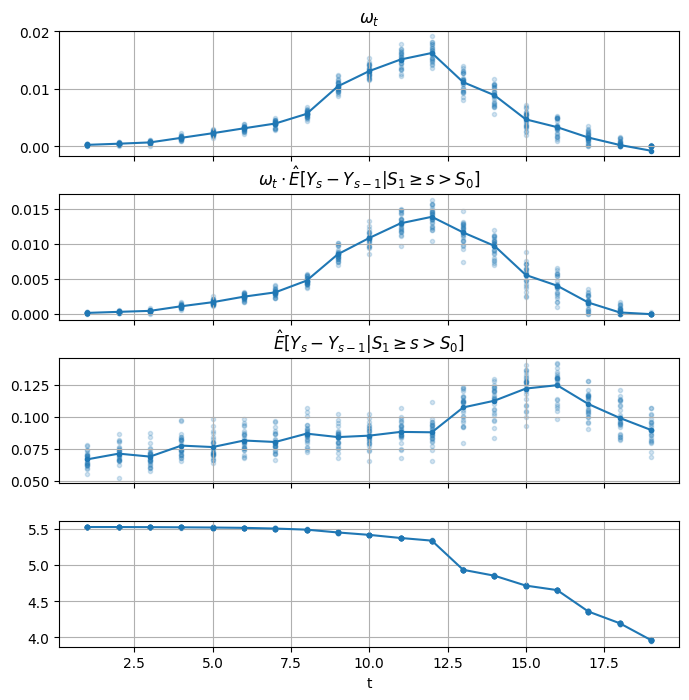

In [15]:
%matplotlib inline
fig, axs = plt.subplots(4,1, sharex=True)
fig.set_size_inches(8, 8)
df_res["omega"] = df_res["omega"].clip(0,1)

alpha=.2
axs[0].scatter(df_res["t"], df_res["omega"], alpha=alpha, marker=".")
axs[1].scatter(df_res["t"], df_res["alpha"]*(df_res["omega"].clip(0,1)*1/df_res.groupby(["i"])["omega"].transform("sum")), alpha=alpha, marker=".")
axs[2].scatter(df_res["t"], df_res["alpha"], alpha=alpha, marker=".")
axs[3].scatter(df_res["t"], numpy.log10(df_res["f"]), alpha=alpha, marker=".")

axs[0].plot(df_res_agg["t"], df_res_agg["omega"], alpha=1, marker=".")
axs[1].plot(df_res_agg["t"], df_res_agg["alpha"]*(df_res_agg["omega"].clip(0,1)*1/df_res_agg["omega"].clip(0,1).sum()), alpha=1, marker=".")
axs[2].plot(df_res_agg["t"], df_res_agg["alpha"], alpha=1, marker=".")
#axs[2].plot(df_res["t"], df_res["D_kappaolsY"], alpha=1, marker=".")
axs[3].plot(df_res_agg["t"], numpy.log10(df_res_agg["f"]), alpha=1, marker=".")
#axs[4].plot(df_res["t"], numpy.log10(df_res["f_fs"]), alpha=1, marker=".")


axs[-1].set_xlabel("t")

axs[0].set_title("$\omega_t$")
axs[1].set_title("$\omega_t\cdot \hat{E}[Y_{s}-Y_{s-1}|S_1\geq s>S_0]$")
axs[2].set_title("$\hat{E}[Y_{s}-Y_{s-1}|S_1\geq s>S_0]$")


axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[3].grid()
#axs[4].grid()

fig.subplots_adjust(hspace=.3)

plt.show()

In [16]:
(df_res["omega"]*df_res["alpha"]).sum()*1/df_res["omega"].sum()

0.09385485949609293

### Conclusions for QOB data

- The overall effect size is 9.4% and significantly larger than the OLS estimate, yet it is smaller than the IV value of roughly 11%.

- For the range up to and including $S=12$ the estimate is roughly 8.5% and thus larger than the OLS estimate but smaller than the OLS.

- It appears interesting that the effect size jumps at $S=13$ to a value larger than 10%.

- This suggests that the effect is non constant over $S$. However, the computation of $\kappa_t$ seems subtle. It would require a much more careful analysis if this kind of analysis is prone to biases, contamination etc.